



1. Download Google Word2Vec pre-trined model (embeddings) [https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing]
2. It is huge and contains tons of garbage. Thus, we retain only a small subset of the words used in the sample text.
3. Having words embedded, we may consider the text as a jiggling trajectory of a "sense" point in 300-dimentional space. 
4. To reveal the underlying "big moves", we're smoothing this trajectory by applying the Moving Average technique.

 

## imports, boilerplate

In [18]:
# all we need:

%matplotlib inline

import numpy as np 
import PIL.Image
import pickle
import string
import IPython.display
import math
 
import matplotlib
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
from scipy.interpolate import interpn,interp1d
from scipy.interpolate import Rbf 


In [2]:
def just_words(filename):
    with open(filename, "r", encoding="utf8") as f:
        txt = f.read() 
        exclude = set(string.punctuation)
        #remove punctuation
        txt = ''.join(ch for ch in txt if ch not in exclude)
        #split into words
        words = txt.split();
        
    return words

## Make Google's Word2Vec subset
Retain the words used in Potter text only.
See [this notebook](Make%20Google's%20Word2Vec%20subset.ipynb)


## Install Barnes-Hut-SNE lib

In [3]:
%%sh
pip install scikit-learn

In [3]:
#see if it works
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
model.fit_transform(X) 


array([[ 0.00017599,  0.00003993],
       [ 0.00009891,  0.00021913],
       [ 0.00018554, -0.00009357],
       [ 0.00009528, -0.00001407]])

## Read our small subset of Google's Word2Vec emeddings
to make it, run [this notebook](Make%20Google's%20Word2Vec%20subset.ipynb)

In [3]:
with open("potter_embeddings.txt", "rb") as myFile:
    embeddings = pickle.load(myFile)
    
#split keys and values into 2 arrays
vocab  = list(embeddings.keys())
values = list(embeddings.values())

print("vocab size=%d"%len(vocab))

vocab size=6520


### Reduce the dimentiality using the default Barnes-Hut method

In [6]:

model = TSNE(n_components=2, random_state=0, verbose=2, metric="cosine")
   
np.set_printoptions(suppress=True) 
embeddings_low = model.fit_transform(values) 


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6520
[t-SNE] Computed conditional probabilities for sample 2000 / 6520
[t-SNE] Computed conditional probabilities for sample 3000 / 6520
[t-SNE] Computed conditional probabilities for sample 4000 / 6520
[t-SNE] Computed conditional probabilities for sample 5000 / 6520
[t-SNE] Computed conditional probabilities for sample 6000 / 6520
[t-SNE] Computed conditional probabilities for sample 6520 / 6520
[t-SNE] Mean sigma: 0.299266
[t-SNE] Iteration 25: error = 1.4655219, gradient norm = 0.0068404
[t-SNE] Iteration 50: error = 1.4499004, gradient norm = 0.0070788
[t-SNE] Iteration 75: error = 1.3532823, gradient norm = 0.0024637
[t-SNE] Iteration 100: error = 1.3270346, gradient norm = 0.0020687
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.327035
[t-SNE] Iteration 125: error = 1.2789158, gradient norm = 0.0015787
[t-SNE] Itera

### plot the result


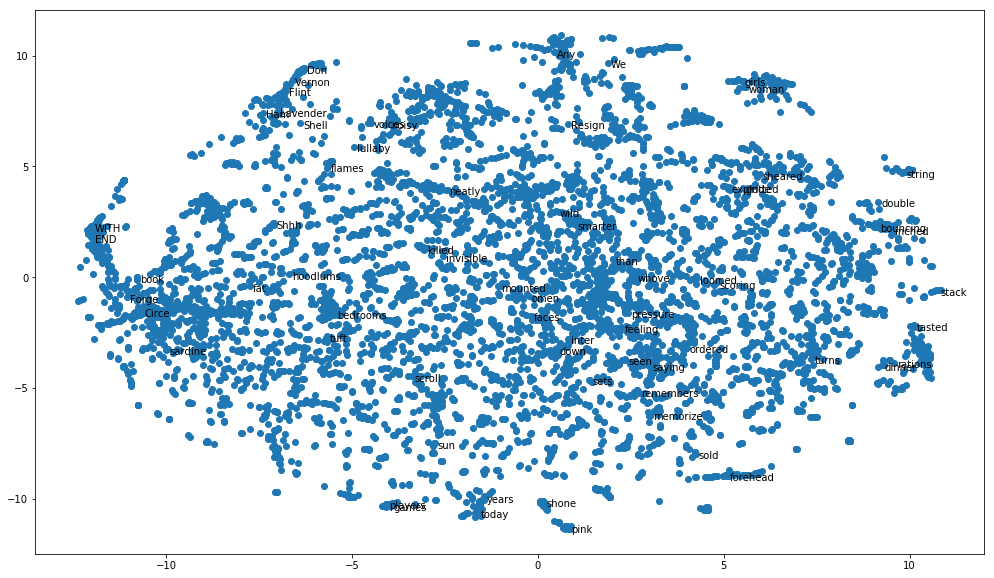

In [7]:
vis_x = embeddings_low[:, 0]
vis_y = embeddings_low[:, 1]
fig = plt.figure(figsize=(17, 10))
plt.scatter(vis_x, vis_y, marker="o")
for i, w in enumerate(vocab[0:70]):
    plt.annotate(
                w,
                xy = (vis_x[i], vis_y[i]), xytext = (3, 3),
                textcoords = 'offset points', ha = 'left', va = 'top')

plt.show()

In [8]:
#save the subset as pickle
embeddings_low_dict = dict(zip(vocab, embeddings_low))

with open("potter_embeddings_low.txt", "wb") as file:
    pickle.dump(embeddings_low_dict, file)

## Define some functions

In [50]:

def dist (a, b):
    return scipy.spatial.distance.pdist([a,b],'euclidean')[0]

def showarray(a, fmt='png'):
    im = a - a.min()
    im = im * (255.0/im.max())

    im = np.uint8(im)
    PIL.Image.fromarray(im).save('out.temp.png', fmt)
    #Yes, it's better to write it into StringIO/BytesIO, but .. 
    IPython.display.display(IPython.display.Image(data='out.temp.png'))
    
def normArrya(a):
    im = a - a.min()
    im = im * (1.0/im.max())

    return im
    

def move_average(old_val, new_val, decay=0.9998):
    return old_val*decay + new_val*(1.0-decay);

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 


## Read the text to analyze

In [5]:
words = just_words("potter.txt");

print ("There are %s words"%(len(words)))
print("sample: %s"%words[0:50]) 

There are 77599 words
sample: ['Harry', 'Potter', 'and', 'the', 'Sorcerers', 'Stone', 'CHAPTER', 'ONE', 'THE', 'BOY', 'WHO', 'LIVED', 'Mr', 'and', 'Mrs', 'Dursley', 'of', 'number', 'four', 'Privet', 'Drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'They', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because']


In [90]:
EMB_SIZE=300;
WORDS_WINDOW=50;



# Move a really heavy (innertial) point in the embeddings space

In [91]:
average_embedding = np.zeros(EMB_SIZE)
image = np.zeros([EMB_SIZE,0])

def oneHot(arr):
    arr=arr-min(arr)
    arr/=max(arr)
    return arr.astype(int)

def ReLU(x):
    return x * (x > 0)


dist_x=[]
dist_y=[]

last_potter_pos=np.ones(EMB_SIZE)
last_ron_pos=np.ones(EMB_SIZE)

i = 0
for word in words:
    if word in embeddings:        
        embedding = embeddings[word][0:EMB_SIZE]
        average_embedding = move_average(average_embedding, embedding, 0.999)
        
        if(word=="Harry" or word=="Potter"):
            last_potter_pos=move_average(last_potter_pos, average_embedding,0.5)

        if(word=="Ron" or word=="Weasley"):
            last_ron_pos=move_average(last_ron_pos, average_embedding,0.5)
        
       
        if((i+1) % WORDS_WINDOW==0):        
             #append next column to the image:
            image=np.c_[ image,  average_embedding]
            
            distance= -dist(last_potter_pos, last_ron_pos);
            
            dist_x.append(i);
            dist_y.append(distance);
            
            
     
    i+=1
        
print ("total points:%d"%(len(dist_x)))
print ("total values:%d"%(len(dist_y)))


total points:1412
total values:1412


# Plot the smoothed trajectory.
### each column corresponds to 300-dimentional point on a smoothed path.

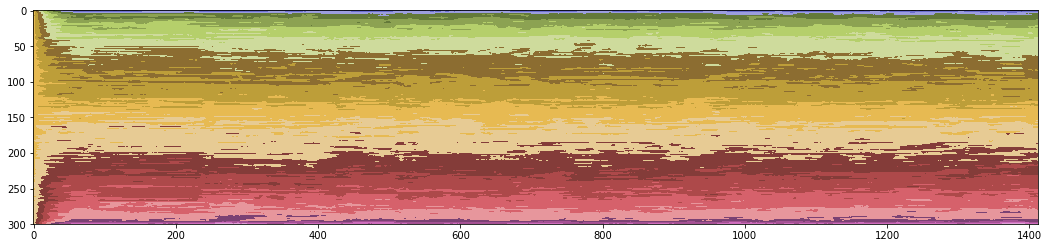

In [92]:
# showarray(image)
image=normArrya(image)
imageS = sorted(image, key=lambda x: x.sum())

plt.figure(figsize=(18, 7))

plt.imshow(imageS, cmap='Vega20b', interpolation='bicubic')
plt.show()


(300, 1412)
(100, 1412, 3)
[[[ 0.53907116  0.53364789  0.53684325]
  [ 0.54730384  0.53850786  0.53905661]
  [ 0.55366844  0.54865128  0.54253578]
  ..., 
  [ 0.69594601  0.66269558  0.63313034]
  [ 0.6973721   0.66682604  0.62618911]
  [ 0.69898237  0.66464948  0.62084399]]]


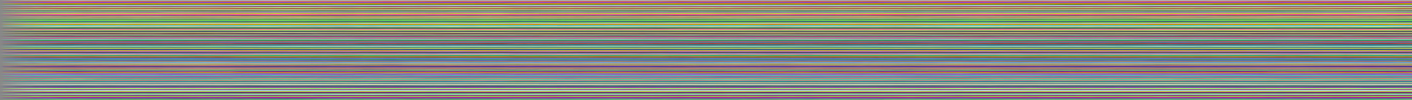

(100, 1412, 3)


In [93]:
print (image.shape)

img2=np.zeros([image.shape[0]//3, image.shape[1], 3])
print (img2.shape)

for x in range(0, image.shape[0], 3):
    for y in range(image.shape[1]):
        img2[x//3, y, 0] = image[x, y]
        img2[x//3, y, 1] = image[x+1, y]
        img2[x//3, y, 2] = image[x+2, y]
        
# img2=image.reshape(image.shape[0]*image.shape[1]).reshape([-1, image.shape[1], 3], order='F')
print(img2[0:1])
showarray(img2)
print (img2.shape)


In [94]:

minx=min(dist_x)
maxx=max(dist_x)

in1 = interp1d(dist_x, dist_y, kind='cubic')


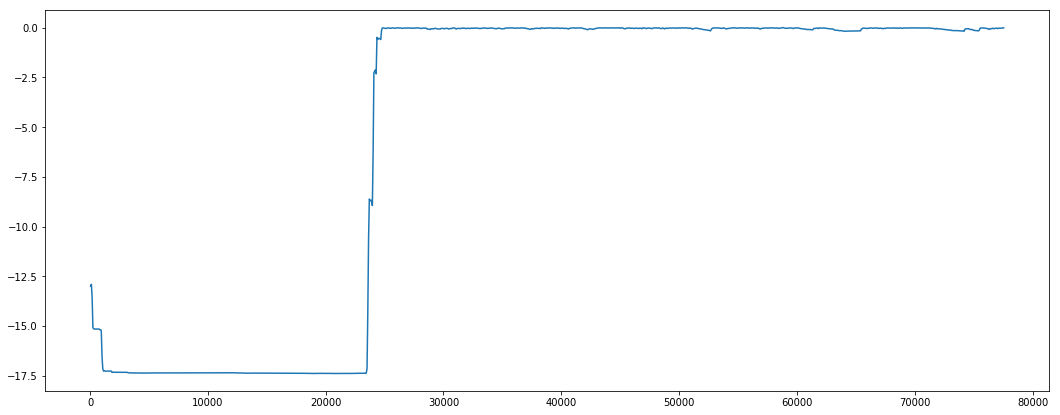

In [95]:
x = np.linspace(minx, maxx, num=1200)

plt.figure(figsize=(18, 7))
plt.plot( x, in1(x), '-') 

plt.show()